In [1]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, ConstantKernel, Matern, Exponentiation
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import warnings
warnings.filterwarnings("ignore")

from common import detpep10exp, load_detpep10exp_dataset, plot_init, plot_3d

## Analyze different kernels

In [38]:
# Plot setup
plot_init()

# Load dataset
X, y = load_detpep10exp_dataset(n_samples=15, sample_range=(0.01, 1))
print(X.shape)
print(y.shape)

# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=43
)

# Dict to save results
scores = {}

(3375, 3)
(3375,)


### Radial basis function (RBF) kernel

In [39]:
# Define length scale
ls = 1.
# Initialize kernel
kernel = RBF(length_scale=ls)
# Train
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=30)
gpr.fit(X_train, y_train)
# Evaluate
score = gpr.score(X_test, y_test)
print('R2 for length scale {}: {}'.format(ls, score))
scores['rbf'] = score

R2 for length scale 1.0: 0.9999999976809768


### Matern kernel

In [40]:
# Define length scale and nu
ls = 1.
nu = 1.5
# Initialize kernel
kernel = Matern(length_scale=ls, nu=nu)
# Train
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=30)
gpr.fit(X_train, y_train)
# Evaluate
score = gpr.score(X_test, y_test)
print('R2 for length scale {} and nu {}: {}'.format(ls, nu, score))
scores['matern'] = score

R2 for length scale 1.0 and nu 1.5: 0.9999983786522908


### Dot product

In [41]:
# Define sigma
sigma = 1
# Initialize kernel
kernel = DotProduct(sigma_0=sigma)
# Train
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=30)
gpr.fit(X_train, y_train)
# Evaluate
score = gpr.score(X_test, y_test)
print('R2 for sigma {}: {}'.format(sigma, score))
scores['dot product'] = score

R2 for sigma 1: 0.7423640501529283


### Dot product + exponentiation

In [42]:
# Define sigma
sigma = 1
# Initialize kernel
kernel = DotProduct(sigma_0=sigma)
kernel = Exponentiation(kernel, 2)
# Train
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=40)
gpr.fit(X_train, y_train)
# Evaluate
score = gpr.score(X_test, y_test)
print('R2 for sigma {}: {}'.format(sigma, score))
scores['dot product + exponentiation'] = score

R2 for sigma 1: 0.981275763428991


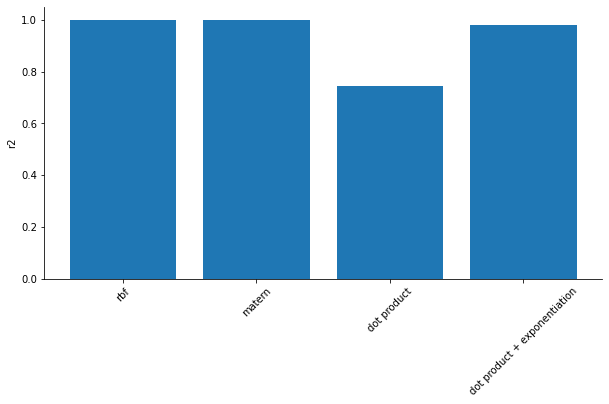

In [45]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(list(scores.keys()), list(scores.values()))
ax.set_ylabel('r2')
ax.tick_params(axis='x', rotation=45)
plt.show()

### Uncertainty and generalization

Here we use a **rbf kernel** and measure the level of uncertainty for all datapoints (left plot) which is simply the standard deviation at each of the function value at each evaluated value for x.

Next, we look at the uncertainty if we train only on a limit range and test outside our training range. This will also reveal something about the extrapolation capabilities of our model.

For this purpose, we train our model only on datapoints for x3 < 0.5. Then, we report the R^2 for both sub-regions (x3 >= 0.5 and x3 < 0.5). In addition to that, we plot the uncertainty levels over the entire range (right plot).

R2 score on full test set is 1.00
R2 score on trained region is 1.00
R2 score on untrained region is -0.89


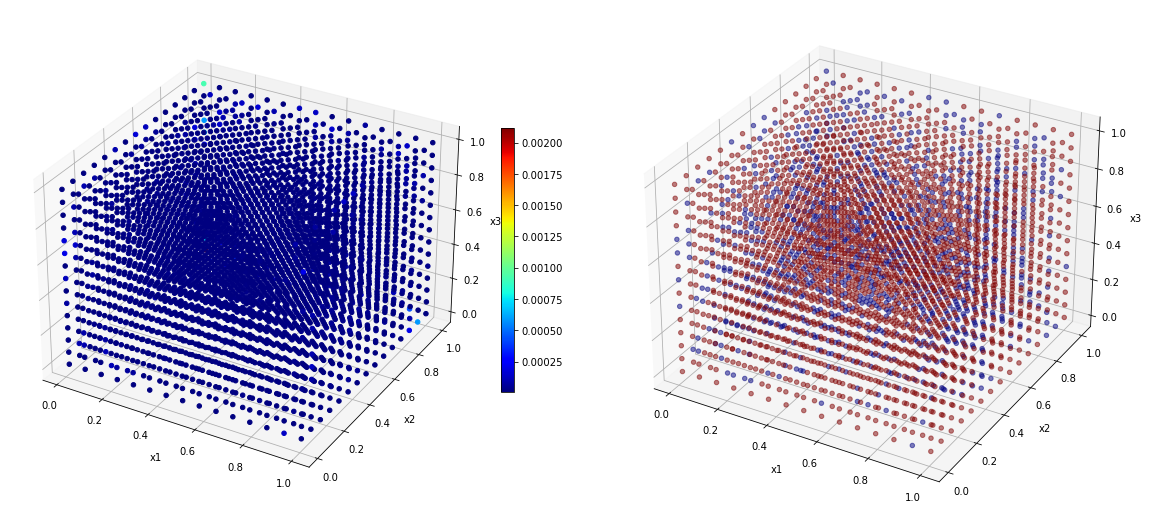

In [48]:
# Initialize kernel
ls = 1.
kernel = RBF(length_scale=ls)

# Load dataset and create train test split
X, y = load_detpep10exp_dataset(n_samples=15, sample_range=(0.01, 1))
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=43
)

# Train on full train dataset
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)
gpr.fit(X_train, y_train)

# Predict on all datapoints
y_pred, y_std_full = gpr.predict(X, return_std=True)

# Get score on entire test set
score = gpr.score(X_test, y_test)

# Train on dataset with x3 < 0.5
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)
gpr.fit(X_train[X_train[:, 2]<0.5, :], y_train[X_train[:, 2]<0.5])

# Score on trained sub-region
trained_score = gpr.score(X_test[X_test[:, 2]<0.5, : ], y_test[X_test[:, 2]<0.5])

# Score on untrained sub-region
untrained_score = gpr.score(X_test[X_test[:, 2]>=0.5, : ], y_test[X_test[:, 2]>=0.5])

# Get prediction on entire range
y_pred, y_std_half = gpr.predict(X, return_std=True)

# Print results
print('R2 score on full test set is {:.2f}'.format(score))
print('R2 score on trained region is {:.2f}'.format(trained_score))
print('R2 score on untrained region is {:.2f}'.format(untrained_score))

# Plot
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(121, projection='3d')
plot_3d(X, y_std_full, ax=ax, colorbar=True)
ax = fig.add_subplot(122, projection='3d')
ax = plot_3d(X_train, np.ones(y_train.shape[0]), colorbar=False, vmin=0, vmax=1, ax=ax, alpha=0.5)
plot_3d(X_test, np.zeros(y_test.shape[0]), colorbar=False, vmin=0, vmax=1, ax=ax, alpha=0.5)
plt.show()

# Plot
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(121, projection='3d')
plot_3d(X, y_std_full, vmin=0, vmax=1, ax=ax, colorbar=True)
ax = fig.add_subplot(122, projection='3d')
plot_3d(X, y_std_half, vmin=0, vmax=1, ax=ax)
plt.show()

### Confidence

To say something about the confidence (or overconfidence) of our model, we relate the prediction error to our uncertainty. If our model is very certain (low std) but has a high prediction error, we are overconfidence. To this end, we compute the z-score which represents the distance of the actual function error from our prediction mean in terms of standard deviations of our prediction. We then take the absolute value of this and plot it. In regions with a high absolute z-score, we are overconfident with respect to our prediction.

<Axes3DSubplot:xlabel='x1', ylabel='x2'>

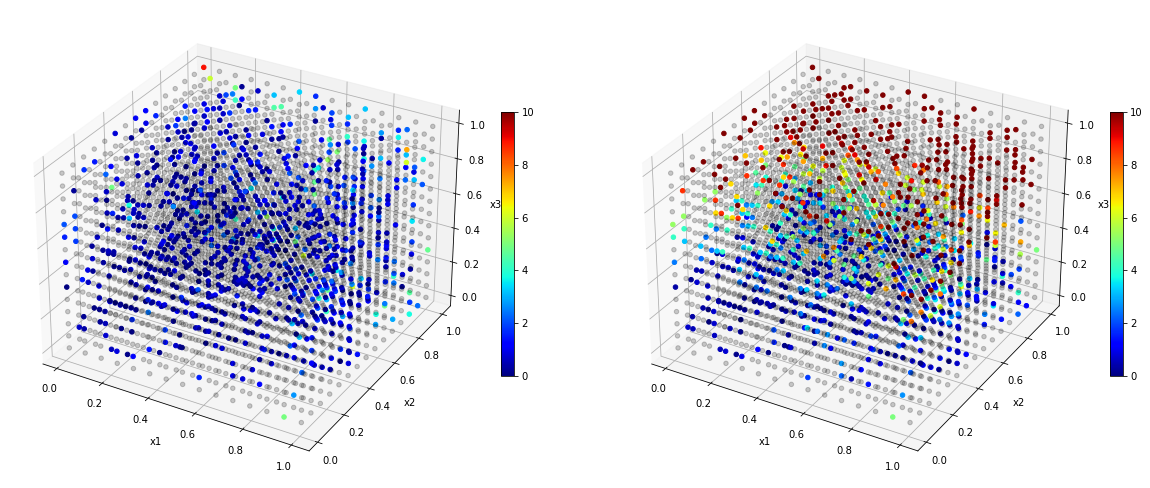

In [49]:
# Train on full train dataset
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)
gpr.fit(X_train, y_train)

# Predict on test set
y_pred, y_std = gpr.predict(X_test, return_std=True)

# Compute confidence as distance of the prediction
# from the actual data point in terms of standard deviations
abs_z_score = np.abs(y_test - y_pred) / y_std

# Train on dataset with x3 < 0.5
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)
gpr.fit(X_train[X_train[:, 2]<0.5, :], y_train[X_train[:, 2]<0.5])

# Predict on test set
y_pred, y_std = gpr.predict(X_test, return_std=True)

# Compute confidence as distance of the prediction
# from the actual data point in terms of standard deviations
abs_z_score_half = np.abs(y_test - y_pred) / y_std

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(121, projection='3d')
ax = plot_3d(X_test, abs_z_score, ax=ax, vmin=0, vmax=10)
plot_3d(X_train, np.ones(X_train.shape[0]), ax=ax, cmap='gray', colorbar=False, alpha=0.2)
ax = fig.add_subplot(122, projection='3d')
ax = plot_3d(X_test, abs_z_score_half, ax=ax, vmin=0, vmax=10)
plot_3d(X_train, np.ones(X_train.shape[0]), ax=ax, cmap='gray', colorbar=False, alpha=0.2)

Next, we do the same, but now the combination of **dot product** and **exponentiation kernel**. We note that the uncertainty is very small even for the case where we exclude half of the datapoints.

R2 score on full test set is 0.98
R2 score on trained region is 0.97
R2 score on untrained region is 0.33


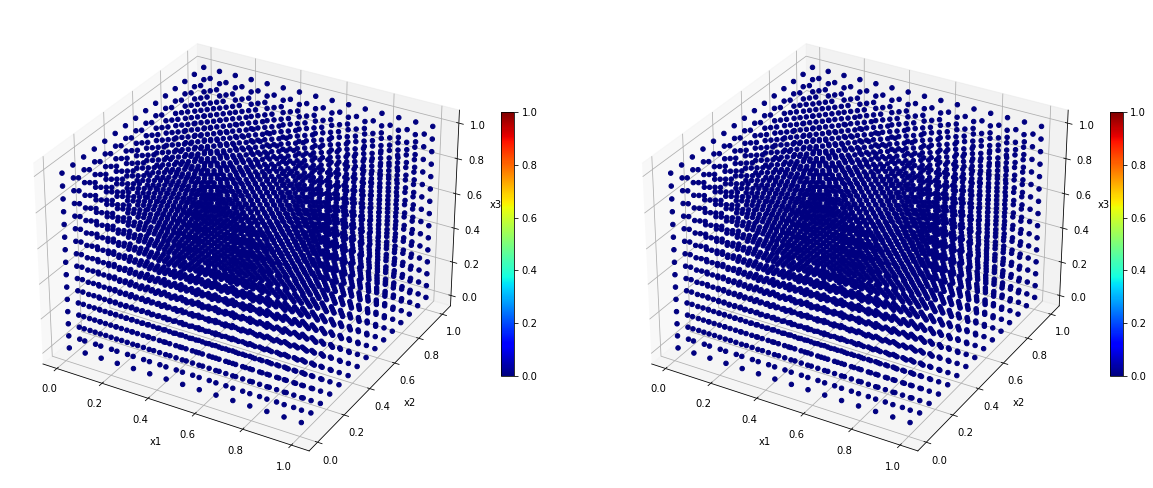

In [19]:
# Initialize kernel
sigma = 1
kernel = DotProduct(sigma_0=sigma)
kernel = Exponentiation(kernel, 2)

# Load dataset and create train test split
X, y = load_detpep10exp_dataset(n_samples=15, sample_range=(0.01, 1))
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=43
)

# Train on full dataset
full_gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)
full_gpr.fit(X_train, y_train)

# Predict on all datapoints
y_pred, y_std_full = full_gpr.predict(X, return_std=True)

# Get score on entire test set
score = full_gpr.score(X_test, y_test)

# Train on dataset with x3 < 0.5
half_gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)
half_gpr.fit(X_train[X_train[:, 2]<0.5, :], y_train[X_train[:, 2]<0.5])

# Score on trained sub-region
trained_score = half_gpr.score(X_test[X_test[:, 2]<0.5, : ], y_test[X_test[:, 2]<0.5])

# Score on untrained sub-region
untrained_score = half_gpr.score(X_test[X_test[:, 2]>=0.5, : ], y_test[X_test[:, 2]>=0.5])

# Get prediction on entire range
y_pred, y_std_half = half_gpr.predict(X, return_std=True)

# Print results
print('R2 score on full test set is {:.2f}'.format(score))
print('R2 score on trained region is {:.2f}'.format(trained_score))
print('R2 score on untrained region is {:.2f}'.format(untrained_score))

# Plot
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(121, projection='3d')
plot_3d(X, y_std_full, vmin=0, vmax=1, ax=ax, colorbar=True)
ax = fig.add_subplot(122, projection='3d')
plot_3d(X, y_std_half, vmin=0, vmax=1, ax=ax)
plt.show()

And here again, we plot the overconfidence rate, this time for the **dot product** and **exponentiation kernel**.

<Axes3DSubplot:xlabel='x1', ylabel='x2'>

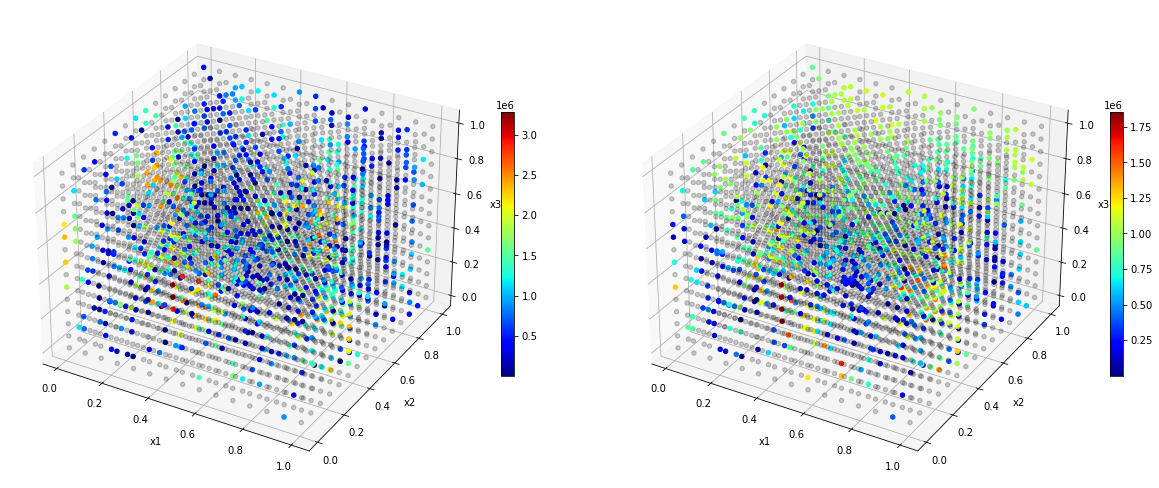

In [18]:
# Predict on test set
y_pred, y_std = full_gpr.predict(X_test, return_std=True)

# Compute confidence as distance of the prediction
# from the actual data point in terms of standard deviations
abs_z_score = np.abs(y_test - y_pred) / y_std

# Predict on test set
y_pred, y_std = half_gpr.predict(X_test, return_std=True)

# Compute confidence as distance of the prediction
# from the actual data point in terms of standard deviations
abs_z_score_half = np.abs(y_test - y_pred) / y_std

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(121, projection='3d')
ax = plot_3d(X_test, abs_z_score, ax=ax)
plot_3d(X_train, np.ones(X_train.shape[0]), ax=ax, cmap='gray', colorbar=False, alpha=0.2)
ax = fig.add_subplot(122, projection='3d')
ax = plot_3d(X_test, abs_z_score_half, ax=ax)
plot_3d(X_train, np.ones(X_train.shape[0]), ax=ax, cmap='gray', colorbar=False, alpha=0.2)

### Adding noise to the data

Here, we will noise to all of the datapoints (train and test).

In [20]:
noise_scores = {}

# Load dataset
X, y = load_detpep10exp_dataset(n_samples=15, sample_range=(0.01, 1))

# Add noise
y = y + np.random.normal(loc=0., scale=2, size=y.shape)

# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=43
)

# ------------------------------ RBF kernel ------------------------------
# Define length scale and noise level
ls = 1.
nl = 1.
# Train
rbf_gpr = GaussianProcessRegressor(kernel=RBF(length_scale=ls), n_restarts_optimizer=30)
rbf_gpr.fit(X_train, y_train)
# Evaluate
score = rbf_gpr.score(X_test, y_test)
print('R2 on noisy dataset using rbf kernel: {:.2f}'.format(score))
noise_scores['rbf'] = score

# --------------------------- RBF + white kernel ---------------------------
# Train
rbfw_gpr = GaussianProcessRegressor(kernel=RBF(length_scale=ls) + WhiteKernel(noise_level=nl), n_restarts_optimizer=30)
rbfw_gpr.fit(X_train, y_train)
# Evaluate
score = rbfw_gpr.score(X_test, y_test)
print('R2 on noisy dataset using rbf + white kernel: {:.2f}'.format(score))
noise_scores['rbf + white'] = score

# --------------------------- Dot + exponentiation ---------------------------
# Train
dot_gpr = GaussianProcessRegressor(kernel=Exponentiation(DotProduct(sigma_0=1), 2), n_restarts_optimizer=30)
dot_gpr.fit(X_train, y_train)
# Evaluate
score = dot_gpr.score(X_test, y_test)
print('R2 on noisy dataset using exponentiation + dot product kernel: {:.2f}'.format(score))
noise_scores['dot + exponentiation'] = score

# ------------------------ Dot + exponentiation + white ------------------------
# Train
dotw_gpr = GaussianProcessRegressor(kernel=Exponentiation(DotProduct(sigma_0=1), 2) + WhiteKernel(noise_level=nl), n_restarts_optimizer=30)
dotw_gpr.fit(X_train, y_train)
# Evaluate
score = dotw_gpr.score(X_test, y_test)
print('R2 on noisy dataset using exponentiation + dot product kernel + white kernel: {:.2f}'.format(score))
noise_scores['dot + exponentiation + white'] = score

# Bar plot
fig, ax = plt.subplots()
ax.bar(list(noise_scores.keys()), list(noise_scores.values()))
ax.tick_params(axis='x', rotation=45)
plt.show()

R2 on noisy dataset using rbf kernel: 0.80
R2 on noisy dataset using rbf + white kernel: 0.89
R2 on noisy dataset using exponentiation + dot product kernel: 0.91
R2 on noisy dataset using exponentiation + dot product kernel + white kernel: 0.89


### Uncertainty and noise

Here we check how adding the noise and the white kernel affects the uncertainty of our model.

In [24]:
# Get predictions on entire range
y_pred_rpf, y_std_rbf = rbf_gpr.predict(X, return_std=True)
y_pred_rbfw, y_std_rbfw = rbfw_gpr.predict(X, return_std=True)

# Plot
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(121, projection='3d')
plot_3d(X, y_std_rbf, vmin=0, vmax=1, ax=ax, colorbar=True)
ax = fig.add_subplot(122, projection='3d')
plot_3d(X, y_std_rbfw, vmin=0, vmax=1, ax=ax, colorbar=True)

# Predict on test set
y_pred, y_std = rbf_gpr.predict(X_test, return_std=True)
# Compute confidence as distance of the prediction
# from the actual data point in terms of standard deviations
rbf_z_score = np.abs(y_test - y_pred) / y_std

# Predict on test set
y_pred, y_std = rbfw_gpr.predict(X_test, return_std=True)
# Compute confidence as distance of the prediction
# from the actual data point in terms of standard deviations
rbfw_z_score = np.abs(y_test - y_pred) / y_std

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(121, projection='3d')
ax = plot_3d(X_test, rbf_z_score, ax=ax, vmin=0, vmax=20)
plot_3d(X_train, np.ones(X_train.shape[0]), ax=ax, cmap='gray', colorbar=False, alpha=0.2)
ax = fig.add_subplot(122, projection='3d')
ax = plot_3d(X_test, rbfw_z_score, ax=ax, vmin=0, vmax=20)
plot_3d(X_train, np.ones(X_train.shape[0]), ax=ax, cmap='gray', colorbar=False, alpha=0.2)

<Axes3DSubplot:xlabel='x1', ylabel='x2'>

Here, we will noise only to our test samples and measure how well we can predict on the true underlying function data without noise.

R2 on noisy training samples using rbf kernel: 0.86
R2 on noisy training samples using exponentiation + dot product kernel: 0.98


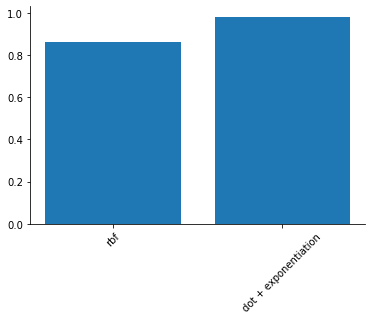

In [25]:
noise_scores = {}

# Load dataset
X, y = load_detpep10exp_dataset(n_samples=15, sample_range=(0.01, 1))

# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=43
)

# Add noise
y_train = y_train + np.random.normal(loc=0., scale=2, size=y_train.shape)

# ------------------------------ RBF kernel ------------------------------
# Define length scale and noise level
ls = 1.
nl = 1.
# Train
gpr = GaussianProcessRegressor(kernel=RBF(length_scale=ls), n_restarts_optimizer=30)
gpr.fit(X_train, y_train)
# Evaluate
score = gpr.score(X_test, y_test)
print('R2 on noisy training samples using rbf kernel: {:.2f}'.format(score))
noise_scores['rbf'] = score

# --------------------------- Dot + exponentiation ---------------------------
# Train
gpr = GaussianProcessRegressor(kernel=Exponentiation(DotProduct(sigma_0=1), 2), n_restarts_optimizer=30)
gpr.fit(X_train, y_train)
# Evaluate
score = gpr.score(X_test, y_test)
print('R2 on noisy training samples using exponentiation + dot product kernel: {:.2f}'.format(score))
noise_scores['dot + exponentiation'] = score

# Bar plot
fig, ax = plt.subplots()
ax.bar(list(noise_scores.keys()), list(noise_scores.values()))
ax.tick_params(axis='x', rotation=45)
plt.show()